In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Should increase beta to =0.1 for stability?

In [3]:
dt = 0.04
noise_var = 20
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2500,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100
)
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.1,
        solver_settings=optsettings,
        fixed_colloc_weight=50.,
        fixed_data_weight=1.,
        max_inner_iterations=500,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(19.46181835, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/2500 [00:00<?, ?it/s]

Iteration 0, loss = 1.978e+06, gradnorm = 2.853e+09, alpha = 4.167, improvement_ratio = 0.9293
Iteration 1, loss = 4.778e+05, gradnorm = 6.599e+09, alpha = 4.167, improvement_ratio = 0.7613
Iteration 2, loss = 1.821e+05, gradnorm = 1.582e+09, alpha = 4.167, improvement_ratio = 0.6287
Iteration 3, loss = 9.35e+04, gradnorm = 1.161e+09, alpha = 4.167, improvement_ratio = 0.5073
Iteration 4, loss = 2.682e+04, gradnorm = 7.301e+08, alpha = 4.167, improvement_ratio = 0.7739
Iteration 5, loss = 8.376e+03, gradnorm = 2.85e+08, alpha = 3.472, improvement_ratio = 0.9454
Iteration 100, loss = 7.148e+03, gradnorm = 0.008493, alpha = 0.002362, improvement_ratio = 1.888
Iteration 200, loss = 7.148e+03, gradnorm = 0.009445, alpha = 2.853e-11, improvement_ratio = 2.733
Iteration 300, loss = 7.148e+03, gradnorm = 0.009651, alpha = 8.333e-17, improvement_ratio = 4.504
Iteration 400, loss = 7.148e+03, gradnorm = 0.007617, alpha = 8.333e-17, improvement_ratio = 10.96
Line Search Failed!
Final Iteration R

In [4]:
metrics

{'coeff_mets': {'precision': 0.7777777777777778,
  'recall': 1.0,
  'f1': 0.875,
  'coeff_rel_l2': 0.15639537342257617,
  'coeff_rmse': 0.9002865002258388,
  'coeff_mae': 0.2755137295035735},
 'data_mets': {'mse': Array(44.88583591, dtype=float64),
  'rmse': np.float64(6.699689239671253),
  'mae': np.float64(4.722026125705432),
  'max_abs_error': np.float64(29.29061957090795),
  'normalized_mse': Array(0.01153775, dtype=float64),
  'relative_l2_error': np.float64(0.1073968045012478)},
 'model_params': {'show_progress': True,
  'sigma2_est': Array(19.46181835, dtype=float64),
  'data_weight': 1.0,
  'colloc_weight': 50.0}}

In [5]:
model.print()

(x)' = -9.403 x + 10.517 y
(y)' = -0.382 1 + 25.967 x + -0.982 y + -0.917 x z
(z)' = 4.400 1 + -2.869 z + 1.033 x y


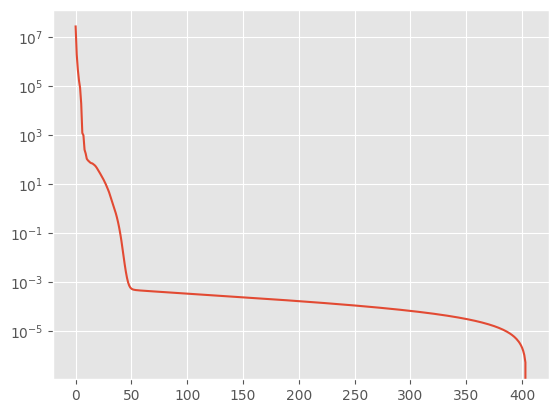

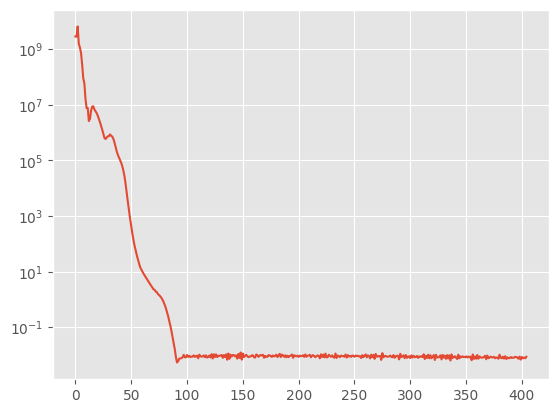

In [6]:
opt = model.opt_result[0]
plt.plot(opt.loss_vals - opt.loss_vals[-1])
plt.yscale('log')
plt.show()
plt.plot(opt.gradnorm)
plt.yscale('log')
plt.show()

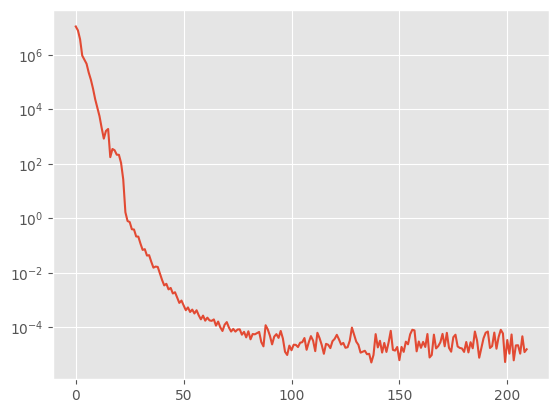

In [13]:
opt = model.opt_result[1]
plt.plot(opt.history['gnorms'][2])
plt.yscale('log')

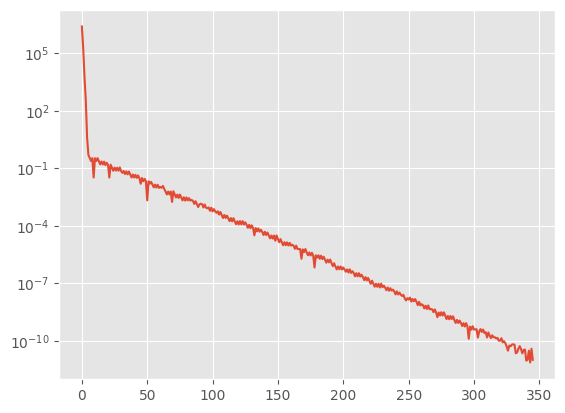

In [14]:
step_index = 0
plt.plot(-1*jnp.diff(jnp.array(opt.history['objval'][step_index])))
plt.yscale('log')

In [15]:
metrics

{'coeff_mets': {'precision': 0.7777777777777778,
  'recall': 1.0,
  'f1': 0.875,
  'coeff_rel_l2': 0.15639537342257617,
  'coeff_rmse': 0.9002865002258388,
  'coeff_mae': 0.2755137295035735},
 'data_mets': {'mse': Array(44.88583591, dtype=float64),
  'rmse': np.float64(6.699689239671253),
  'mae': np.float64(4.722026125705432),
  'max_abs_error': np.float64(29.29061957090795),
  'normalized_mse': Array(0.01153775, dtype=float64),
  'relative_l2_error': np.float64(0.1073968045012478)},
 'model_params': {'show_progress': True,
  'sigma2_est': Array(19.46181835, dtype=float64),
  'data_weight': 1.0,
  'colloc_weight': 50.0}}

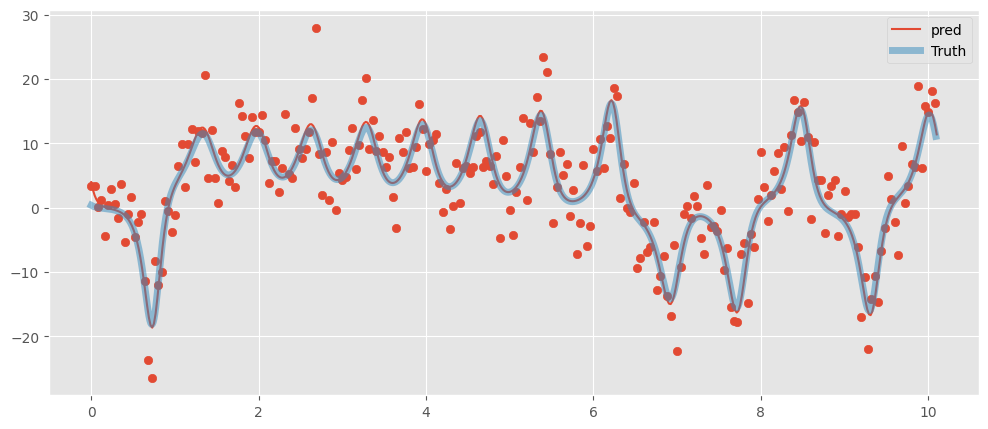

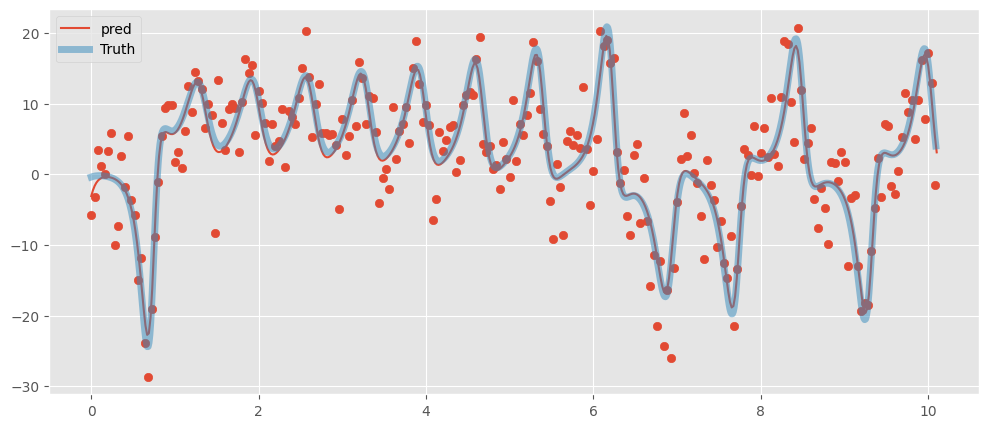

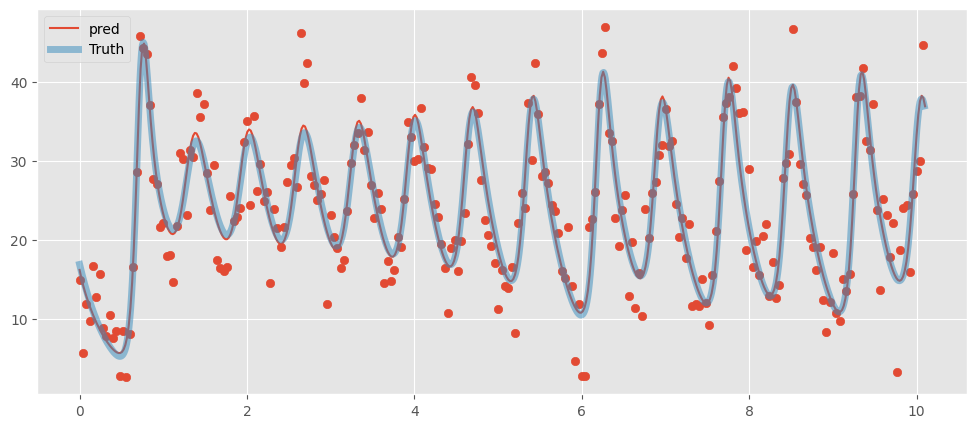

In [16]:
t_grid = jnp.linspace(0,10.1,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.figure(figsize=(12,5))
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i],lw = 5,alpha = 0.5,label = 'Truth')
    plt.legend()
    plt.show()

In [34]:
t_grid = jnp.linspace(0,10,500)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

I = jnp.eye(A.shape[1])
refit_theta = jnp.linalg.solve(A.T@A + 0.1*I ,A.T@xdot_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer,SSR
stlsq = STLSQ(threshold = 0.25,alpha =0.01,unbias = True)
optimizer = stlsq
# EnsembleOptimizer(
#     stlsq,library_ensemble=True,
#     bagging = True,
#     n_models = 5000,
#     n_candidates_to_drop=2
#     )
# optimizer = SSR(criteria = 'model_residual',kappa = 0.1,alpha = 0.01)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -9.547 x + 10.408 y
(y)' = -0.289 1 + 26.400 x + -0.989 y + -0.935 x z
(z)' = 3.332 1 + -2.819 z + 1.024 x y


In [35]:
jnp.mean((dynamics_model.predict(expdata.x_test,refit_theta) - expdata.x_dot_test)**2)/jnp.var(expdata.x_dot_test)

Array(0.00612143, dtype=float64)